<a href="https://colab.research.google.com/github/wavhalkomal/AAI-551-A-Engineering-Programming-Python/blob/main/data2vec_vision_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll fine-tune a model pre-trained using data2vec. We'll leverage the `transformers` library for loading the pre-trained model and we'll then append a custom classification head for fine-tuning. For data handling we'll use `tf.data`.

Checkout the data2vec paper [here](https://arxiv.org/abs/2202.03555) and the model documentation page [here](https://huggingface.co/docs/transformers/main/en/model_doc/data2vec).

## Setup

In [ ]:
# Otherwise TF's data2vec vision model won't be available.
# Date: May 06, 2022
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import TFAutoModelForImageClassification, TFData2VecVisionModel
from transformers import create_optimizer

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Primary constants

In [ ]:
# Model
IMAGE_SIZE = [224, 224]
MODEL_ID = "facebook/data2vec-vision-base"  # pre-trained model from which to fine-tune

# Data
BATCH_SIZE = 16  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data related utilities

In [ ]:
# Closely aligns with https://github.com/huggingface/transformers/blob/main/src/transformers/models/beit/feature_extraction_beit.py
# in regards to resizing and normalization.


def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    dataset = dataset.map(preprocess, AUTO).batch(BATCH_SIZE)
    # Transpose because the `transformers` model has a leading channel dimension.
    dataset = dataset.map(lambda x, y: (tf.transpose(x, [0, 3, 1, 2]), y), AUTO)
    return dataset.prefetch(AUTO)

## Load and visualize the `tf_flowers` dataset

In [ ]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


In [ ]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

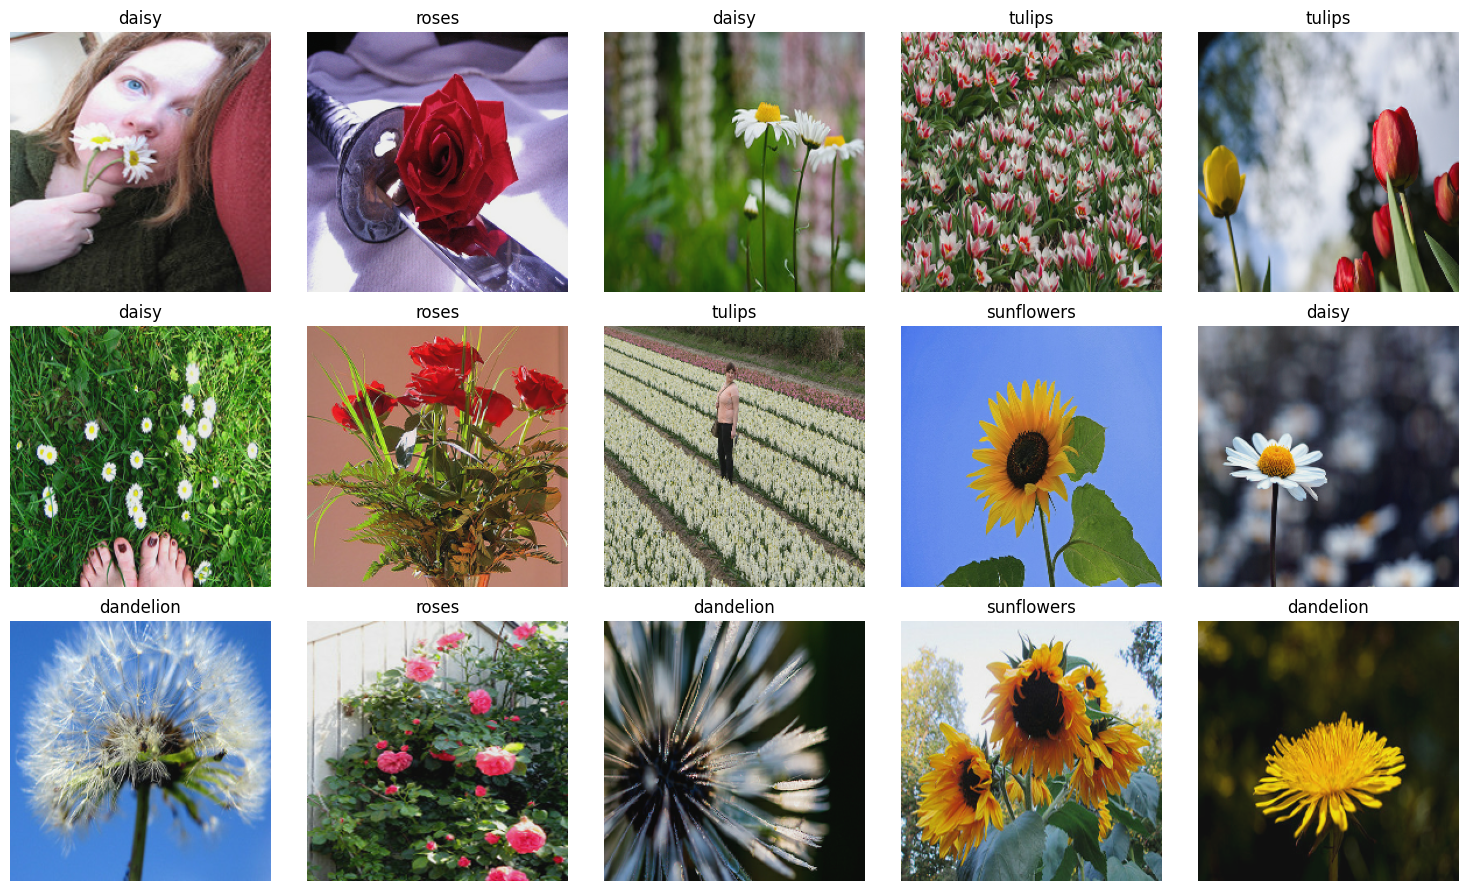

In [ ]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n].numpy().transpose(1, 2, 0) * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFData2VecVisionModel

class Data2VecLayer(layers.Layer):
    def __init__(self, model_id, **kwargs):
        super(Data2VecLayer, self).__init__(**kwargs)
        self.base_model = TFData2VecVisionModel.from_pretrained(model_id)
        self.base_model.trainable = True

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        return x.last_hidden_state[:, 0]

def get_model():
    inputs = layers.Input((3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
    x = Data2VecLayer(MODEL_ID)(inputs, training=False)  # Use the custom layer
    outputs = layers.Dense(5)(x)
    model = keras.Model(inputs, outputs)
    print(model)

    return model

## Model building utilities

In [ ]:

########################
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

# Create some regression data
X_regression = np.expand_dims(np.arange(0, 1000, 5), axis=1)
y_regression = np.expand_dims(np.arange(100, 1100, 5), axis=1)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

tf.random.set_seed(42)

# Recreate the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Change the loss and metrics of our compiled model
model.compile(loss=tf.keras.losses.mae, # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metric to be regression-specific

# Fit the recompiled model
model.fit(X_reg_train, y_reg_train, epochs=100)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 579.8008 - mae: 579.8008
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 465.7419 - mae: 465.7419  
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 352.3561 - mae: 352.3561 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 237.9859 - mae: 237.9859 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 120.3665 - mae: 120.3665 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.5203 - mae: 48.5203 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85.8618 - mae: 85.8618 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.5394 - mae: 75.5394 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.3541 - mae: 46.3541 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.9178 - mae: 50.9178 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.0007 - mae: 41.0007 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.1029 - mae: 44.1029 
Epoch 13/100


In [ ]:
################################ Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5).reshape(-1,1)
y_regression = np.arange(100, 1100, 5).reshape(-1,1)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# Setup random seed
tf.random.set_seed(42)

# Recreate the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Change the loss and metrics of our compiled model
model.compile(loss=tf.keras.losses.mae, # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metric to be regression-specific

# Fit the recompiled model
model.fit(X_reg_train, y_reg_train, epochs=100)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 594.4870 - mae: 594.4870
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 471.4838 - mae: 471.4838 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 348.0980 - mae: 348.0980 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 222.1202 - mae: 222.1202 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.9301 - mae: 92.9301   
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.6567 - mae: 64.6567 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91.4656 - mae: 91.4656 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.6305 - mae: 65.6305 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.4247 - mae: 43.4247 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.0955 - mae: 50.0955 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.1834 - mae: 41.1834 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.1803 - mae: 44.1803 
Epoch 13/100
5/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFData2VecVisionModel

class Data2VecLayer(layers.Layer):
    def __init__(self, model_id, **kwargs):
        super(Data2VecLayer, self).__init__(**kwargs)
        self.base_model = TFData2VecVisionModel.from_pretrained(model_id)
        self.base_model.trainable = True

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training).last_hidden_state
        # Global average pooling to get a fixed-size output
        x = tf.reduce_mean(x, axis=1)
        return x

def get_model():
    inputs = layers.Input((3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
    x = Data2VecLayer(MODEL_ID)(inputs, training=False)  # Use the custom layer
    outputs = layers.Dense(5)(x)
    model = keras.Model(inputs, outputs)
    print(model)

    return model


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFData2VecVisionModel

class Data2VecLayer(layers.Layer):
    def __init__(self, model_id, **kwargs):
        super(Data2VecLayer, self).__init__(**kwargs)
        self.base_model = TFData2VecVisionModel.from_pretrained(model_id)
        self.base_model.trainable = True

    def call(self, inputs, training=False):
        # Directly access the pooler_output
        outputs = self.base_model(inputs, training=training, output_hidden_states=True)
        return outputs.pooler_output

def get_model():
    inputs = layers.Input((3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
    x = Data2VecLayer(MODEL_ID)(inputs, training=False)  # Use the custom layer
    outputs = layers.Dense(5)(x)
    model = keras.Model(inputs, outputs)
    print(model)

    return model

In [ ]:
model = get_model()
model.summary()

## Compile model and train it

In [ ]:
num_train_epochs = 3
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0


num_train_steps = (num_train // BATCH_SIZE) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
num_train_epochs = 3
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0

history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_train_epochs)

## Visualize training progress

In [ ]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

## References

* https://github.com/sayakpaul/cait-tf/blob/main/notebooks/finetune.ipynb
* https://colab.research.google.com/drive/1M4CEl6Jgf4KgqLHb4_bi3acJvNNLZqZd